# Dependencies

New Environment Created: caa env
Packages: Python 3.7

Added packages: Descartes, Geopandas

# Collect Data

Data were collected from the Data.gov site with the urls:

List of every arrest in NYC going back to 2006 through the end of the previous calendar year.
https://catalog.data.gov/dataset/nypd-arrests-data-historic

https://catalog.data.gov/dataset/nypd-shooting-incident-data-historic

The data can be exported in many formats including JSON and XML, however CSV offered the most raw source of data and was therefore selected to begin analysis.

At the time of writing data.gov did not offer a streaming or RESTful endpoint for this data to be remotely gathered, therefore the raw source file was downloaded from data.gov then uploaded to this project as NYPD_Shooting_Incident_Data_Historic.csv.

In [1]:
source_arrest_file = "NYPD_Arrests_Data_Historic.csv"
source_shooting_file = "NYPD_Shooting_Incident_Data_Historic.csv"

# Exploratory Data Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import random

import folium
from shapely.geometry import Point, Polygon

%matplotlib inline

In [3]:
# experiment reproducibility 
# print(str(int(time.time())))
# 1574546920

In [4]:
random.seed(1574546920)

In [5]:
arrest_df = pd.read_csv(source_arrest_file)
shooting_df = pd.read_csv(source_shooting_file)

# Exploratory Data Analysis

In [6]:
arrest_df.shape

(4798339, 18)

In [7]:
shooting_df.shape

(20659, 18)

In [8]:
arrest_df.head(1)

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
0,173130602,12/31/2017,566.0,"MARIJUANA, POSSESSION",678.0,MISCELLANEOUS PENAL LAW,PL 2210500,V,Q,105,0.0,25-44,M,BLACK,1063056.0,207463.0,40.735772,-73.715638


In [9]:
shooting_df.head(1)

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
0,169180023,09/09/2017,3:57:00,STATEN ISLAND,120,0.0,NaN,False,NaN,NaN,NaN,25-44,M,BLACK,959975,171772,40.638126,-74.087467


Initial review of the datasets. The arrest data has 18 variables with 4,798,339 observations while the shooting data has 18 variables with only 20,659 observations. 

Both datasets contain an incident date (ARREST_DATE and OCCUR_DATE) but only the shooting data contains a time (OCCUR_TIME). 

Both datasets contain a JURISDICTION_CODE.

Both datesets include a precinct (ARREST_PRECINCT and PRECINCT). 

Both datasets contain a borough (ARREST_BORO and BORO), however the arrest data's borough data is abstracted. 

Both datasets contain a lat long for the event.

First we will turn the date of event into a datetime variable so we can review the events over time. 

In [10]:
arrest_df['date'] = pd.to_datetime(arrest_df.ARREST_DATE)
shooting_df['date'] = pd.to_datetime(shooting_df.OCCUR_DATE)

In [11]:
boro_key = {'Q': 'Queens', 'K': 'Bronx', 'M':'Manhattan', 'S':'Staten Island', 'B': 'Brooklyn', np.nan: np.nan}
arrest_df['BORO'] = [boro_key[k] for k in arrest_df.ARREST_BORO]


Next we will review which of the variable in each dataset have mission values.

In [12]:
for cat in arrest_df:
    print(cat + " nan values: " + str(arrest_df[cat].isna().sum()))

ARREST_KEY nan values: 0
ARREST_DATE nan values: 0
PD_CD nan values: 220
PD_DESC nan values: 8870
KY_CD nan values: 8870
OFNS_DESC nan values: 8870
LAW_CODE nan values: 196
LAW_CAT_CD nan values: 16103
ARREST_BORO nan values: 8
ARREST_PRECINCT nan values: 0
JURISDICTION_CODE nan values: 10
AGE_GROUP nan values: 17
PERP_SEX nan values: 0
PERP_RACE nan values: 0
X_COORD_CD nan values: 1
Y_COORD_CD nan values: 1
Latitude nan values: 1
Longitude nan values: 1
date nan values: 0
BORO nan values: 8


In [23]:
clean_arrest_df = arrest_df.dropna()

In [14]:
for cat in shooting_df:
    print(cat + " nan values: " + str(shooting_df[cat].isna().sum()))

INCIDENT_KEY nan values: 0
OCCUR_DATE nan values: 0
OCCUR_TIME nan values: 0
BORO nan values: 0
PRECINCT nan values: 0
JURISDICTION_CODE nan values: 1
LOCATION_DESC nan values: 11715
STATISTICAL_MURDER_FLAG nan values: 0
PERP_AGE_GROUP nan values: 6857
PERP_SEX nan values: 6823
PERP_RACE nan values: 6823
VIC_AGE_GROUP nan values: 0
VIC_SEX nan values: 0
VIC_RACE nan values: 0
X_COORD_CD nan values: 0
Y_COORD_CD nan values: 0
Latitude nan values: 0
Longitude nan values: 0
date nan values: 0


With regards to relevant data about the activities captured in the data: 

The arrest dataset has slightly under 9000 or ~.2% mission data. 

The shooting dataset has 6857 mission values, or ~33% mission data, however of note those values are missing from the perp data fields rather than the victim of crime. This may mean those values were redacted by a judge or other data protection mechanisms.


In [24]:
clean_shooting_df = shooting_df.dropna()

In [16]:
arrest_df.groupby('PD_DESC').agg({'ARREST_KEY': pd.Series.nunique})
#len(arrest_df.groupby('PD_DESC').count())

,ARREST_KEY
PD_DESC,
"A.B.C.,FALSE PROOF OF AGE",391
ABORTION 1,10
"ABORTION 2, 1, SELF",1
ABSCONDING FROM WORK RELEASE 2,27
"ACCOSTING,FRAUDULENT",2139
...,...
"WEAPONS,DISPOSITION OF",17
"WEAPONS,MFR,TRANSPORT,ETC.",252
"WEAPONS,PROHIBITED USE",36


We note there are 351 unique crime categories - but there are multiple derivatives of the same types of crime such as crimes involving weapons or crimes involving tresspassing. 

If we identify the top 10 most common crimes we can start to understand the dataset more.

In [17]:
top_10_arrests = arrest_df.groupby('PD_DESC').count()['ARREST_KEY'].sort_values(ascending=False).head(10)
display(top_10_arrests)

PD_DESC
MARIJUANA, POSSESSION 4 & 5                   422358
ASSAULT 3                                     376001
THEFT OF SERVICES, UNCLASSIFIED               303359
CONTROLLED SUBSTANCE, POSSESSION 7            278083
NY STATE LAWS,UNCLASSIFIED VIOLATION          225678
LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED    188347
TRAFFIC,UNCLASSIFIED INFRACTION               165647
ASSAULT 2,1,UNCLASSIFIED                      150823
STOLEN PROPERTY 3,POSSESSION                  149877
ROBBERY,UNCLASSIFIED,OPEN AREAS               143263
Name: ARREST_KEY, dtype: int64

We see that Marijuana Possession 4 and 5 are the most previlent crime. From outside research these are both Misdemeanors and including possession of More then 25g - 2oz. and More than 2-8oz. Possession 5+ as seen above area felony drug offenses.

Source: http://ypdcrime.com/penal.law/marijuana-penalties.htm

If we sort by the <i>least</i> common crimes:

In [18]:
arrest_df.groupby('PD_DESC').count()['ARREST_KEY'].sort_values().head(15)

PD_DESC
WOUNDS,REPORTING OF                           1
ABORTION 2, 1, SELF                           1
USING SLUGS, 2ND                              1
FAC. SEXUAL OFFENSE W/CONTROLLED SUBSTANCE    1
LOITERING FOR PROSTITUTION OR                 1
LOITERING,BEGGING                             1
MANUFATURE, TRANSPORT, DEFACE, ETC...         1
MARRIAGE,OFFENSES AGAINST,UNCLASSIFIED        1
RIGHT OF WAY,PEDESTRIAN                       1
PUBLIC HEALTH LAW,UNCLASSIFIED                1
EXHIBITION,OFFENSIVE                          1
MISCHIEF,CRIMINAL     UNCLASSI                1
PEDESTRIAN - WALK/DO NOT WALK                 1
WEAPONS DISPOSITION OF                        2
AGRICULTURE & MARKETS LAW,UNCL                2
Name: ARREST_KEY, dtype: int64

# Comparing PD Description and Offense Description

Now for each precinct I would like to see the most prevelant arrest data by both PD Description and Offense Description.

In [19]:
df_agg = arrest_df.sort_values(['ARREST_PRECINCT']).groupby(['ARREST_PRECINCT','PD_DESC']).agg({'count',sum})
g = df_agg['ARREST_KEY']['count'].groupby(level=0, group_keys=False)
res = g.apply(lambda x: x.sort_values(ascending=False).head(1))

r1 = pd.DataFrame(res).reset_index(level=-1, drop=False)

df_agg = arrest_df.sort_values(['ARREST_PRECINCT']).groupby(['ARREST_PRECINCT','OFNS_DESC']).agg({'count',sum})
g = df_agg['ARREST_KEY']['count'].groupby(level=0, group_keys=False)
res = g.apply(lambda x: x.sort_values(ascending=False).head(1))

r2 = pd.DataFrame(res).reset_index(level=-1, drop=False)

pd.concat([r1,r2], axis=1)

,PD_DESC,count,OFNS_DESC,count
ARREST_PRECINCT,,,,
1,"NY STATE LAWS,UNCLASSIFIED MISDEMEANOR",6899,OTHER STATE LAWS (NON PENAL LAW),7040
5,"NY STATE LAWS,UNCLASSIFIED MISDEMEANOR",6254,OTHER STATE LAWS,6969
6,"MARIJUANA, POSSESSION 4 & 5",4576,DANGEROUS DRUGS,12729
7,"MARIJUANA, POSSESSION 4 & 5",3957,DANGEROUS DRUGS,9622
9,"STOLEN PROPERTY 3,POSSESSION",4166,DANGEROUS DRUGS,11270
...,...,...,...,...
115,ASSAULT 3,9057,DANGEROUS DRUGS,12213
120,"MARIJUANA, POSSESSION 4 & 5",8523,DANGEROUS DRUGS,24567
121,"LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED",3117,DANGEROUS DRUGS,3807


# Geo Data View

We are going to visually plot the arrest data. We know that the >4M points would create a visually dense map so we will limit the information to just those top 10 we created earlier.

First we will quickly look at the Latitude and Longitude data to assess if there are any outliers or anomalies. This is only useful with the context that the general area of NYC is covered between Latitude ~40~67 and Longitude -74.3~-73.6.

In [20]:
np.warnings.filterwarnings('ignore')

{'whiskers': [<matplotlib.lines.Line2D at 0x2cd1a801b08>,
 'caps': [<matplotlib.lines.Line2D at 0x2cd1a7ecfc8>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cd1a7ec208>],
 'medians': [<matplotlib.lines.Line2D at 0x2cd1a7e8c48>],
 'fliers': [<matplotlib.lines.Line2D at 0x2cd1a7e8d08>],
 'means': []}

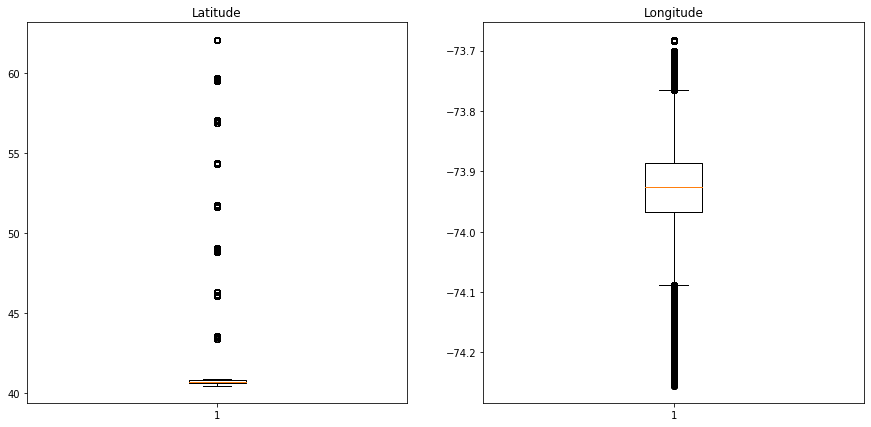

In [21]:
a = [float(i) for i in arrest_df.Latitude]
a = pd.Series(a).dropna()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
ax1.set_title('Latitude')
ax1.boxplot(a)

a = [float(i) for i in arrest_df.Longitude]
a = pd.Series(a).dropna()
ax2.set_title('Longitude')
ax2.boxplot(a)

#### Geoplotting Data

We will use Folium to plot the data on a 2D map. Our intent is to determine if there are major clusters of particular crimes, or areas where crimes are less prevalent.

In [26]:
import folium

crime_colors = ['black', 'm','grey','firebrick','hotpink','green','orangered','goldenrod', 'red','lightseagreen']
crime_colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue']
m = folium.Map(location=[40.758896, -73.985130], zoom_start=10)

#

for i,arrest_type in enumerate(top_10_arrests.keys()): 
        sub = clean_arrest_df[clean_arrest_df.PD_DESC == arrest_type]
        for index, s in sub[0:100].iterrows():
            m.add_child(folium.Marker(location=[s.Latitude, s.Longitude],popup=(folium.Popup(arrest_type)),icon=folium.Icon(color=crime_colors[i],icon_color='black')))
        
m
#map.add_child(fg)

#### Observations from Geoplotted Data

It does not appear that there are any areas with demonstrably more of a single type of crime.

# Arrest Data Timeline

We will plot the data across time to look for trends.

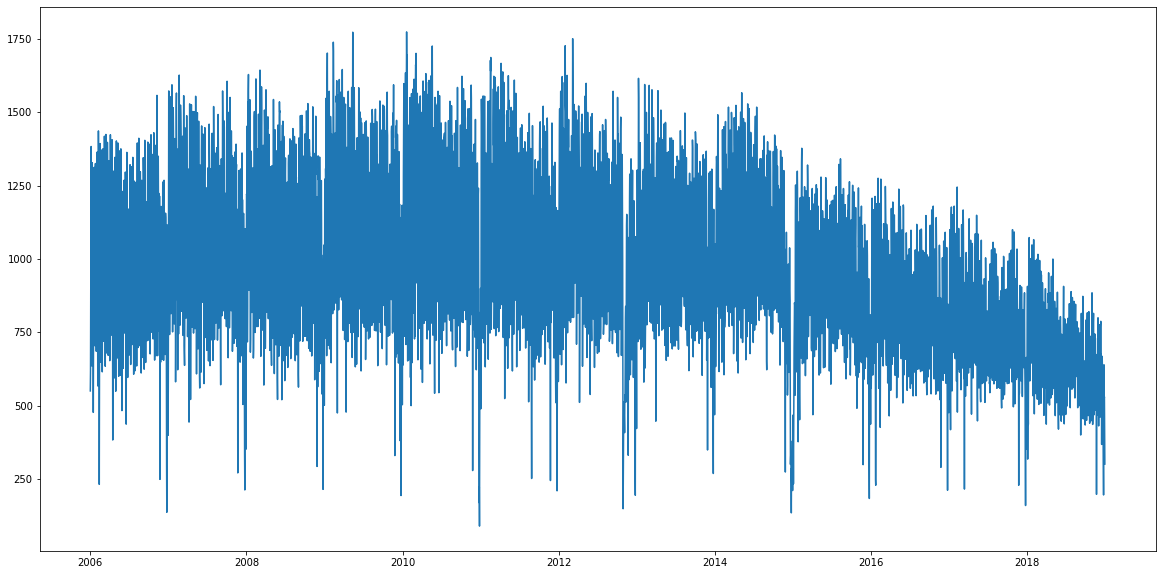

In [27]:
#arrest_df['date'] = pd.to_datetime(arrest_df.ARREST_DATE)
t = arrest_df.groupby('date').count()['ARREST_KEY']
plt.figure(figsize=(20,10))
plt.plot(t)
plt.show()

#### Timeline observations

From the time series plot we can observe a slight downward trend in the overall arrest between 2006 and 2019.

In [28]:
t = arrest_df.groupby(['date', 'PD_DESC']).count().reset_index()

z = ['ARREST_DATE','PD_CD', 'KY_CD', 'OFNS_DESC', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT', 'JURISDICTION_CODE',
 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'BORO']

#### Overall plot of the data

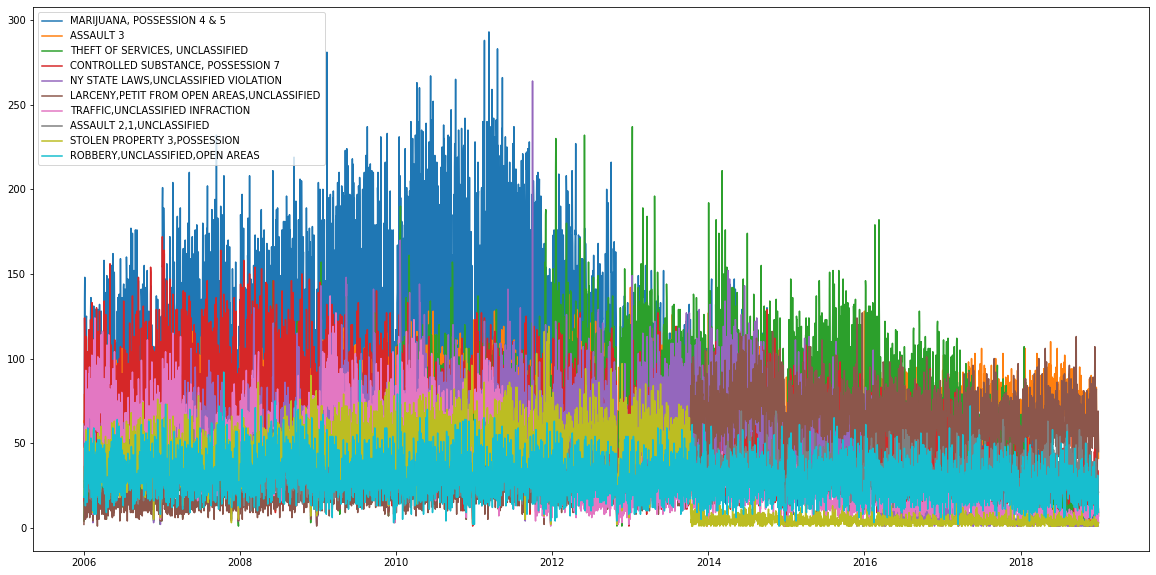

In [32]:
plt.figure(figsize=(20,10))
z = ['PD_DESC','ARREST_DATE','PD_CD', 'KY_CD', 'OFNS_DESC', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT', 'JURISDICTION_CODE',
 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'BORO']

for i,arrest_type in enumerate(top_10_arrests.keys()): 
        sub = clean_arrest_df[clean_arrest_df.PD_DESC == arrest_type]
        t = sub.groupby(['date']).count().reset_index().drop(z, axis=1).dropna()
        t['date'] = pd.to_datetime(t['date'], unit='s')
        t['mdate'] = [mdates.date2num(d) for d in t['date']]
        plt.plot(t.date, t.ARREST_KEY, label=arrest_type)
        
plt.legend(loc="upper left")
plt.show()
plt.close()


#### Time series lines

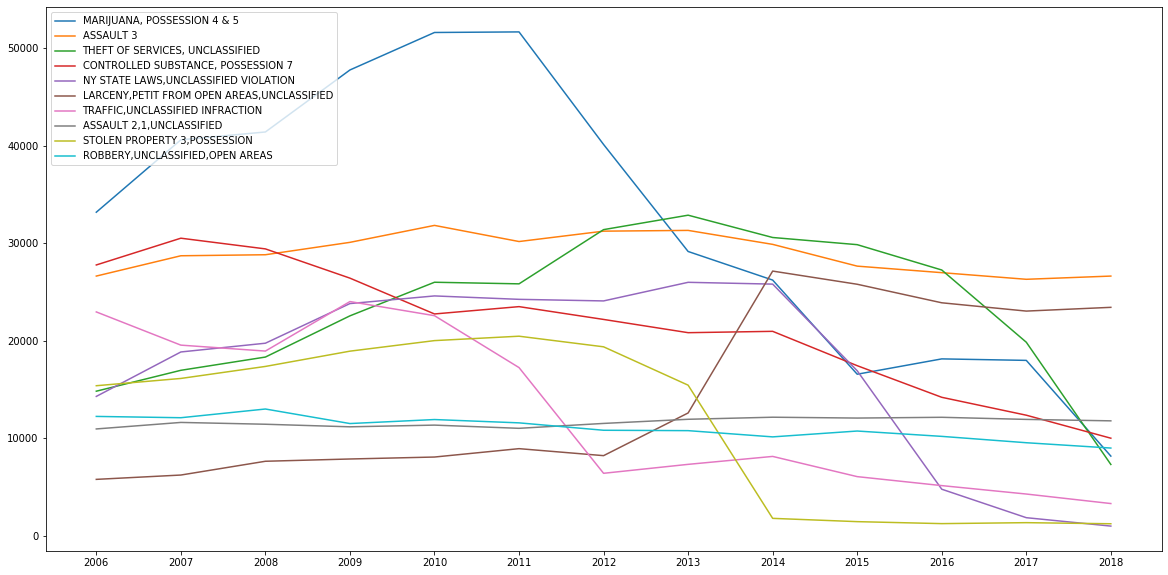

In [35]:
plt.figure(figsize=(20,10))
z = ['date','PD_DESC','ARREST_DATE','PD_CD', 'KY_CD', 'OFNS_DESC', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT', 'JURISDICTION_CODE',
 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'BORO']




for i,arrest_type in enumerate(top_10_arrests.keys()): 
        sub = clean_arrest_df[clean_arrest_df.PD_DESC == arrest_type]
        sub['year'] = [str(y)[-4:] for y in sub.ARREST_DATE]
        t = sub.groupby(['year']).count().reset_index().drop(z, axis=1).dropna()
        t.set_index('year', inplace=True)
        #t['date'] = pd.to_datetime(t['date'], unit='s')
        #t['mdate'] = [mdates.date2num(d) for d in t['date']]
        #t.plot(label=arrest_type)
        plt.plot(t.ARREST_KEY, label=arrest_type)
        
plt.legend(loc="upper left")
plt.show()
plt.close()


#### Linear Trendlines

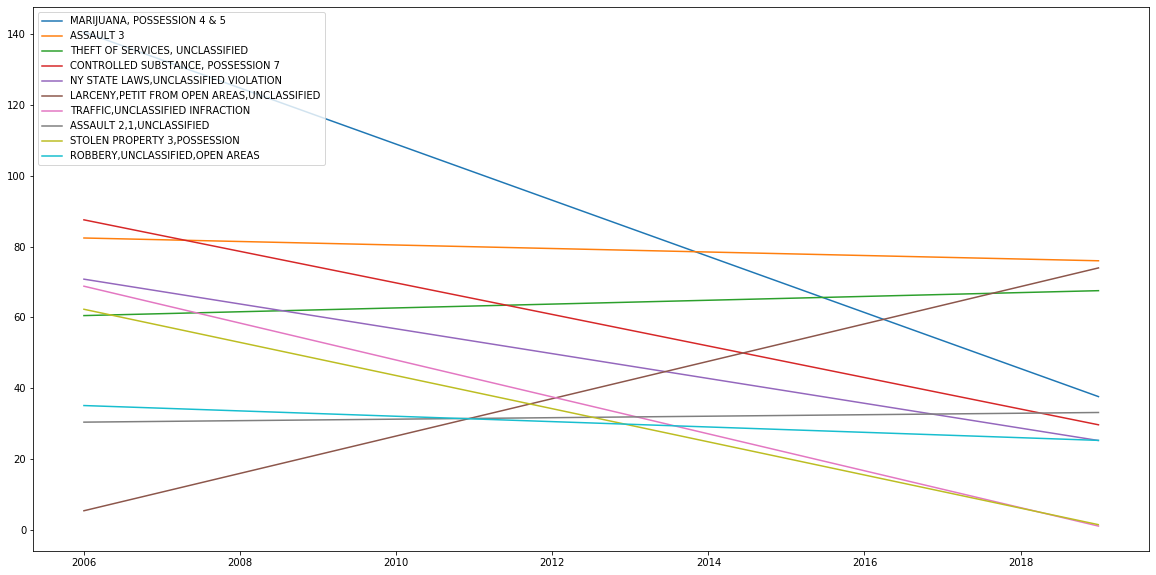

In [36]:
plt.figure(figsize=(20,10))
z = ['PD_DESC','ARREST_DATE','PD_CD', 'KY_CD', 'OFNS_DESC', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT', 'JURISDICTION_CODE',
 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'BORO']

for i,arrest_type in enumerate(top_10_arrests.keys()): 
        sub = clean_arrest_df[clean_arrest_df.PD_DESC == arrest_type]
        t = sub.groupby(['date']).count().reset_index().drop(z, axis=1).dropna()
        t['date'] = pd.to_datetime(t['date'], unit='s')
        t['mdate'] = [mdates.date2num(d) for d in t['date']]
        za = np.polyfit(t.mdate, t.ARREST_KEY, 1)
        p = np.poly1d(za)
        plt.plot(t.date,p(t.mdate,), label=arrest_type)
        
        #plt.plot(t.date, t.ARREST_KEY, label=arrest_type)

plt.legend(loc="upper left")
plt.show()
plt.close()


In [37]:
#clean_arrest['year'] = [pd.to_datetime(str(y)[-4:]) for y in clean_arrest.date]
#clean_arrest['year'] = [pd.to_datetime(y) for y in clean_arrest.year]

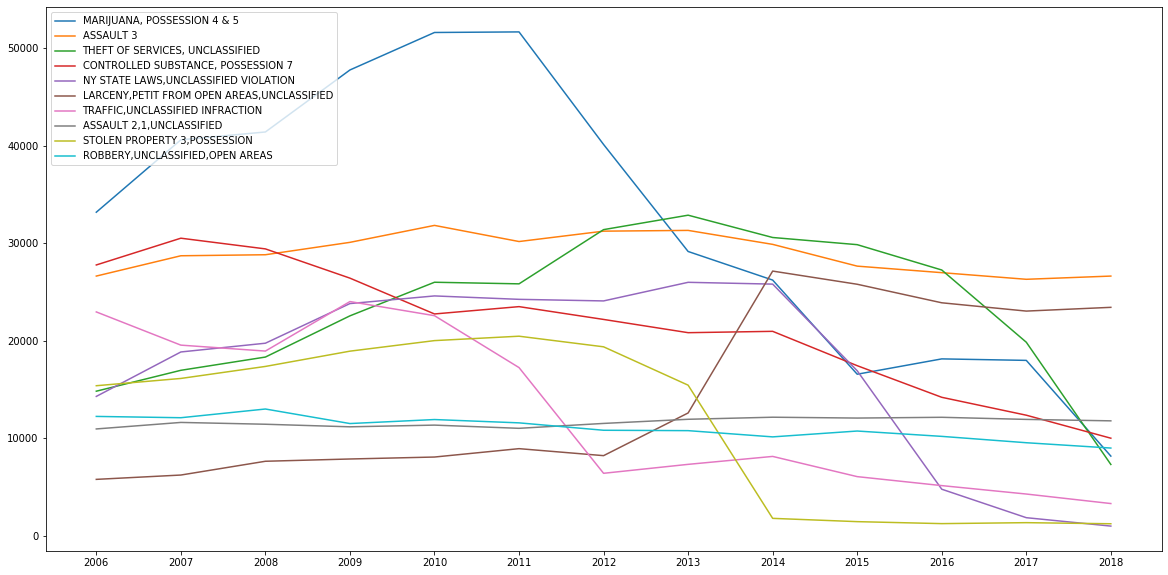

In [39]:
plt.figure(figsize=(20,10))
z = ['date','PD_DESC','ARREST_DATE','PD_CD', 'KY_CD', 'OFNS_DESC', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT', 'JURISDICTION_CODE',
 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'BORO']




for i,arrest_type in enumerate(top_10_arrests.keys()): 
        sub = clean_arrest_df[clean_arrest_df.PD_DESC == arrest_type]
        sub['year'] = [str(y)[-4:] for y in sub.ARREST_DATE]
        t = sub.groupby(['year']).count().reset_index().drop(z, axis=1).dropna()
        t.set_index('year', inplace=True)
        #t['date'] = pd.to_datetime(t['date'], unit='s')
        #t['mdate'] = [mdates.date2num(d) for d in t['date']]
        #t.plot(label=arrest_type)
        plt.plot(t.ARREST_KEY, label=arrest_type)
        
plt.legend(loc="upper left")
plt.show()
plt.close()


### Observations

From the data we see a general downward trend in the overall arrests as well as generally within the top 10 arrest types. That being said we see a steep increase in Larceny from open areas in 2012 and a matching sharp decrease in stolen property 3 in 2013. These could be due to changes in law enforcement tactics or other outside influences. 

# Shooting Data Timeline

### Refresher on Shooting Data

In [40]:
shooting_df.head(5)

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,date
0,169180023,09/09/2017,3:57:00,STATEN ISLAND,120,0.0,NaN,False,NaN,NaN,NaN,25-44,M,BLACK,959975,171772,40.638126,-74.087467,2017-09-09
1,169180027,09/09/2017,22:15:00,BRONX,50,0.0,NaN,False,NaN,NaN,NaN,25-44,M,BLACK HISPANIC,1011288,255912,40.869061,-73.902242,2017-09-09
2,169180025,09/09/2017,18:35:00,BROOKLYN,79,2.0,MULTI DWELL - PUBLIC HOUS,False,NaN,NaN,NaN,18-24,M,BLACK,999888,193014,40.696450,-73.943607,2017-09-09
3,169180024,09/09/2017,15:20:00,BROOKLYN,67,0.0,NaN,False,18-24,M,BLACK,18-24,M,BLACK,997784,172132,40.639137,-73.951236,2017-09-09
4,169180022,09/09/2017,0:20:00,BROOKLYN,61,2.0,MULTI DWELL - PUBLIC HOUS,False,NaN,NaN,NaN,25-44,M,ASIAN / PACIFIC ISLANDER,1001019,156467,40.596134,-73.939619,2017-09-09


In [41]:
shooting_df.columns

Index(['INCIDENT_KEY', 'OCCUR_DATE', 'OCCUR_TIME', 'BORO', 'PRECINCT',
       'JURISDICTION_CODE', 'LOCATION_DESC', 'STATISTICAL_MURDER_FLAG',
       'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'VIC_AGE_GROUP', 'VIC_SEX',
       'VIC_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude',
       'date'],
      dtype='object')

### Strip out the Year to show trend over time

In [42]:
shooting_df['year'] = [str(y)[-4:] for y in shooting_df.OCCUR_DATE]

#### Identify Precinct with Most Shootings

In [45]:
shooting_count = shooting_df.sort_values(['PRECINCT']).groupby(['PRECINCT']).agg({'count',sum})

#murder_true = murder_true.sort_values(by='PRECINCT').groupby(['PRECINCT']).agg({'count',sum})
g = shooting_count['INCIDENT_KEY']['count'].groupby(level=0, group_keys=False)
res = g.apply(lambda x: x.sort_values(ascending=False).head(1))
res.reset_index().sort_values('count', ascending=False).head(10)


,PRECINCT,count
45,75,1165
44,73,1117
38,67,994
49,79,809
25,44,746
28,47,733
27,46,692
21,40,660
50,81,645
69,113,637


### Identify Precinct with Most Murders

In [46]:
murder_true = shooting_df[shooting_df['STATISTICAL_MURDER_FLAG'] == True]

murder_true = murder_true.sort_values(['PRECINCT']).groupby(['PRECINCT']).agg({'count',sum})

#murder_true = murder_true.sort_values(by='PRECINCT').groupby(['PRECINCT']).agg({'count',sum})
g = murder_true['INCIDENT_KEY']['count'].groupby(level=0, group_keys=False)
res = g.apply(lambda x: x.sort_values(ascending=False).head(1))
res.reset_index().sort_values('count', ascending=False).head(10).set_index('PRECINCT')

,count
PRECINCT,
75,218
73,206
67,192
47,164
79,153
46,135
44,134
81,128
113,127


In [47]:
res.reset_index().sort_values('count', ascending=True).head(10).set_index('PRECINCT')

,count
PRECINCT,
19,2
17,2
68,4
18,4
1,5
20,5
78,6
66,6
123,6


### Plot the number of shootings per year

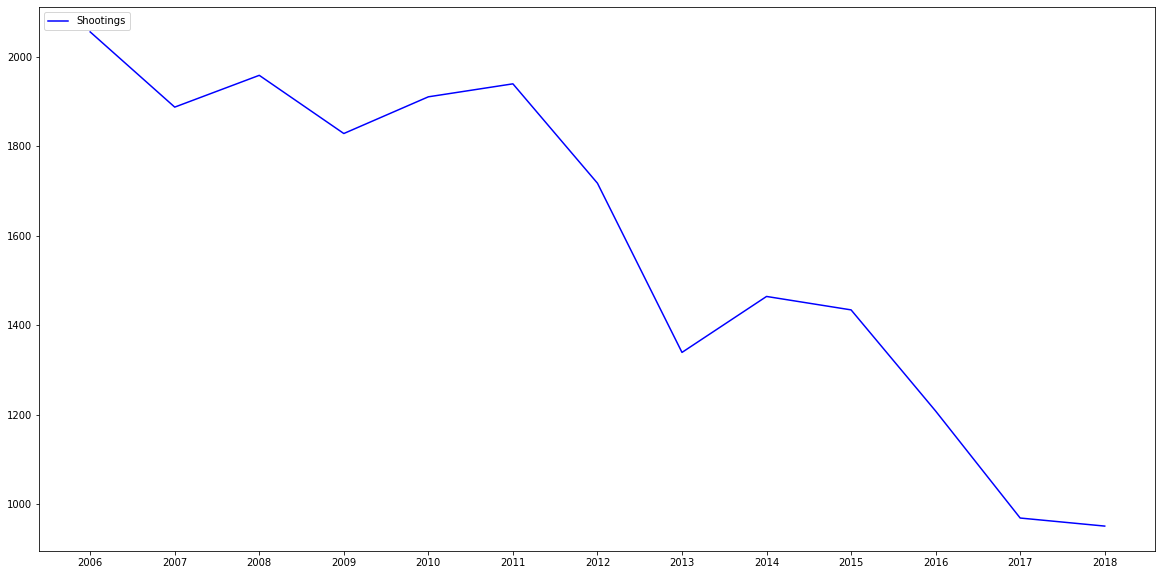

In [48]:
#murder_true = shooting_df[shooting_df['STATISTICAL_MURDER_FLAG'] == True]
#murder_false = shooting_df[shooting_df['STATISTICAL_MURDER_FLAG'] == False]

shooting = shooting_df.groupby(['year']).count().reset_index().dropna()
plt.figure(figsize=(20,10))

plt.plot(shooting.year, shooting.INCIDENT_KEY, color='blue',label='Shootings')

#t[t['STATISTICAL_MURDER_FLAG'] == True].drop('STATISTICAL_MURDER_FLAG',axis=1).plot(color='red',label='Murder')
plt.legend(loc="upper left")
plt.show()
plt.close()
#murder_true = murder_true.sort_values(by='PRECINCT').groupby(['PRECINCT']).agg({'count',sum})
#g = murder_true['INCIDENT_KEY']['count'].groupby(level=0, group_keys=False)
#res = g.apply(lambda x: x.sort_values(ascending=False).head(1))

#### Seperating Shootings which are murder from non-murder

In [49]:

t = shooting_df.groupby(['year', 'STATISTICAL_MURDER_FLAG']).count()['INCIDENT_KEY'].reset_index()
non_murder = t[t['STATISTICAL_MURDER_FLAG'] == False].drop('STATISTICAL_MURDER_FLAG',axis=1).reset_index(drop=True)
murder = t[t['STATISTICAL_MURDER_FLAG'] == True].drop('STATISTICAL_MURDER_FLAG',axis=1).reset_index(drop=True)

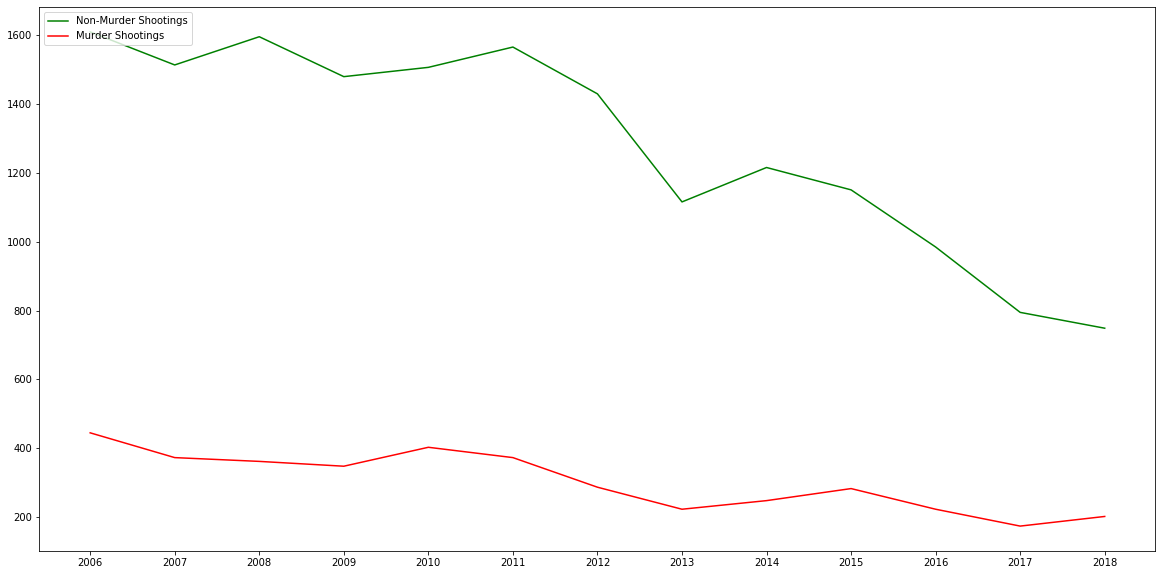

In [50]:
plt.figure(figsize=(20,10))

plt.plot(non_murder.year, non_murder.INCIDENT_KEY, color='green',label='Non-Murder Shootings')
plt.plot(murder.year, murder.INCIDENT_KEY, color='red',label='Murder Shootings')
#t[t['STATISTICAL_MURDER_FLAG'] == True].drop('STATISTICAL_MURDER_FLAG',axis=1).plot(color='red',label='Murder')
plt.legend(loc="upper left")
plt.show()
plt.close()

# Wizardly Data Prep

After we've done the initial Exploratory Data Analysis we will not begin to prep the data for prediction. 

Our first step is to take all of of the categorical variables, including binary, and one hot encode them. This will increase the dataframe dimentionality, but is required.

We will also convert the datetime variables to epochs and drop non-useful variables. 

In [ ]:
# prep shooting df for magic
# one hot encoding
shooting_dummies = ['BORO', 'PRECINCT','JURISDICTION_CODE','STATISTICAL_MURDER_FLAG','PERP_AGE_GROUP','PERP_SEX','PERP_RACE','VIC_AGE_GROUP','VIC_SEX','VIC_RACE']

for sd in shooting_dummies:
    dummies = pd.get_dummies(df['sd'], prefix = sd+'_')
    shooting_df.concat(dummies, axis=1)
    shooting_df.drop(sd, axis=1)
    
# convert DTG to epoch
shooting_df['date_stamp'] = [int(t.timestamp()) for t in shooting_df.date]
shooting_df.drop(['OCCUR_DATE','OCCUR_TIME'], axis=1)

# drop non-useful variables
drop_cols = ['LOCATION_DESC', 'X_COORD_CD', 'Y_COORD_CD', 'INCIDENT_KEY']
shooting_df.drop(drop_cols, axis=1)
    
# prep arrest df for magic
# one hot encoding
arrest_dummies = ['PD_DESC', 'OFNS_DESC', 'BORO', 'ARREST_PRECINCT', 'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE']

for ad in arrest_dummies:
    dummies = pd.get_dummies(df['ad'], prefix = ad+'_')
    arrest_df.concat(dummies, axis=1)
    arrest_df.drop(sd, axis=1)

# convert DTG to epoch
arrest_df['date_stamp'] = [int(t.timestamp())] for t in arrest_df.date]
arrest_df.drop(['ARREST_DATE', 'DATE'], axis=1)

# drop non-useful variables
drop_cols = ['ARREST_KEY', 'PD_CD','KY_CD','LAW_CODE','LAW_CAT_CD','X_COORD_CD','Y_COORD_CD','ARREST_BORO']
arrest_df.drop(drop_cols, axis=1)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.model_selection import train_test_split as tts

def impute_variable(df, var):
    inner_df= df.dropna()
    target = inner_df[var]
    source = inner_df.drop(var, axis=1)
    
    X_train, X_test, y_train, y_test = tts(source, target, test_size=0.30, random_state=1574546920)

    
    clf = knn(n_neighbors=5)
    clf.fit(X_train, y_train)
    pred = clf.predict(df[var])
    
    r_var = [v in df[var] if v is not np.nan else p for v, p in zip(df[var], pred)]
    return r_var

In [ ]:
impute_variable(shooting_df, 'PERP_SEX')

Starting with the Arrest data we will first review the rate of activity by age

In [ ]:
g = arrest_df.groupby(['ARREST_PRECINCT','PD_DESC'])

Manhattan, Brooklyn, Queens, The Bronx, Staten Island

t = arrest_df.groupby('date').count()['ARREST_KEY']

plt.figure(figsize=(20,10))
plt.plot(t)
plt.show()

# PD_Description

# Offense Description

# Arrest Boro

In [ ]:
arrest_df.ARREST_BORO.nunique()

In [ ]:
boros = [boro_key[k] for k in arrest_df.ARREST_BORO]

In [ ]:
boro_key = {'Q': 'Queens', 'K': 'Bronx', 'M':'Manhattan', 'S':'Staten Island', 'B': 'Brooklyn', np.nan: 'None'}
boros = [boro_key[k] for k in arrest_df.ARREST_BORO]

# Arrest Precinct

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(arrest_df.ARREST_PRECINCT, bins=120)
plt.show()

# Age / Sex / Race
AGE_GROUP
PERP_SEX
PERP_RACE

# Lat / Long

Latitude
Longitude